1) Which stochastic optimiser did you choose?
Genetic algorithm

2) Why did you choose this algorithm?
Genetic algorithms allow a large search space and have the inate ability to move away from local minima (or maxima). Requires
calculation of only the fitness function and no gradient calculations are required which makes it computationally favourable. 

3) What constraint handling method(s) are you using and why?
Solution candidates that violate any constraint return a large value when evaluating the cost of that candidate. This forces
the likeliness of this candidate propogating to be extremely low. 

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm


# Making a counter to keep track the times a function has been called
global funccounter
funccounter = np.zeros(5)

### Defining the functions

def f(x):
    global funccounter
    funccounter[0] += 1
    return 1.7781*z2(x)*(x[2]**2) + 0.6224*z1(x)*x[2]*x[3] + 3.1661*(z1(x)**2)*x[3] + 19.84*(z1(x)**2)*x[2]


def g1(x):
    global funccounter
    funccounter[1] += 1
    return 0.00954*x[2]


def g2(x):
    global funccounter
    funccounter[2] += 1
    return 0.0193*x[2]


def g3(x):
    global funccounter
    funccounter[3] += 1
    return x[3]


def g4(x):
    global funccounter
    funccounter[4] += 1
    return -math.pi * x[2]**2 * x[3] - (4/3)*math.pi*x[2]**3


def z1(x):
    return 0.0625*x[0]


def z2(x):
    return 0.0625*x[1]


### Setting parameters for the search space
maxx1x2 = 99
minx1x2 = 1
maxx3x4 = 200.
minx3x4 = 10.

maxg3 = 240
maxg4 = -1296000


In [2]:
### Performing test to validate functons above
x = np.array([1, 35, 11.678, 88.76])
print("Test x: ", x)
print("Objective function output: ", f(x))
print("Constraint function 1 output: ", g1(x))
print("Constraint function 2 output: ", g2(x))
print("Constraint function 3 output: ", g3(x))
print("Constraint function 4 output: ", g4(x))


Test x:  [ 1.    35.    11.678 88.76 ]
Objective function output:  572.77017736475
Constraint function 1 output:  0.11140812000000001
Constraint function 2 output:  0.22538540000000004
Constraint function 3 output:  88.76
Constraint function 4 output:  -44699.10187026799


# Random Search


<ol>
<li> initialise with a random x vector that obeys the constraints on x </li>
<li> evaluate objective function</li>
<li> evaluate if constraints are met</li>
<li> if met, store as current best</li>
<li> repeat steps 1-4</li>
<li> if objective is better, update current best</li>
<li> repeat for a certain number of iterations</li>
</ol>


In [3]:
# setting some placeholders
best_obj = 100000
best_x = np.array([])
fobjlist = []
max_iterations = 4000  # max number of evaluations allowed for any of the functions

In [4]:
def randomsearch(best_obj, best_x, fobjlist, max_iterations):
    i = 0
    while i < max_iterations:

        x_curr = np.array([random.randint(minx1x2, maxx1x2),  # x1
                           random.randint(minx1x2, maxx1x2),  # x2
                           minx3x4 + (maxx3x4-minx3x4) * random.random(),  # x3
                           minx3x4 + (maxx3x4-minx3x4) * random.random()]) # x4

        curr_obj = f(x_curr)

        if curr_obj < best_obj:
            if g1(x_curr) <= z2(x_curr):
                if g2(x_curr) <= z1(x_curr):
                    if g3(x_curr) <= maxg3:
                        if g4(x_curr) <= maxg4:
                            best_obj = curr_obj
                            best_x = x_curr
                            fobjlist.append(best_obj)

        i += 1

    return best_obj, best_x, fobjlist




In [5]:
# run the random search
best_obj, best_x, fobjlist = randomsearch(best_obj, best_x, fobjlist, max_iterations)
print("best objective: ", best_obj)
print("best x:         ", best_x)

best objective:  12278.22026806801
best x:          [27.         14.         64.94477465 26.50293642]


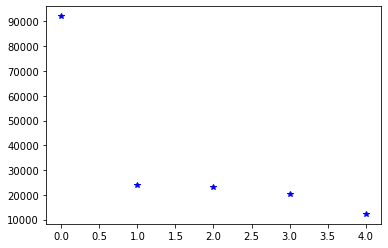

In [6]:
# plot results from random search
fig1 = plt.figure(1)
plt.plot(fobjlist, "b*")
plt.show()

# Genetic Algorithm

In [7]:
def fitfunc(x):
    '''
    if all constraints are met, return the actual fitness function. if not, return a high value to reduce the likeliness that 
    this parent will propogate
    '''
    if checkconstraints(x,[]):
        return f(x)
    else:
        return 1e10

def generateparents(Nparents):
    '''
    generates Nparents amount of parents that obey all constraints
    '''
    parents = []
    i = 0
    while i < Nparents:
        x_curr = np.array([random.randint(minx1x2, maxx1x2),  # x1
                           random.randint(minx1x2, maxx1x2),  # x2
                           minx3x4 + (maxx3x4 - minx3x4) * random.random(),  # x3
                           minx3x4 + (maxx3x4 - minx3x4) * random.random()])  # x4
        if g1(x_curr) <= z2(x_curr):
            if g2(x_curr) <= z1(x_curr):
                if g3(x_curr) <= maxg3:
                    if g4(x_curr) <= maxg4:
                        parents.append(x_curr)
                        i += 1

    return np.array(parents)


def mutate(parents, fitfunc, Nparents, perc):
    '''
    generates children from the parents with good scores and mutates them by adding some noise
    '''
    n = int(len(parents))
    scoresabs = np.array([fitfunc(i) for i in parents])
    scores = np.array([1/fitfunc(i) for i in parents])
    currbestparent, currbestfitval = getfittestparent(parents, fitfunc)
    b = [(i / scores.sum()) for i in scores]

    for i in b:
        if np.isnan(i):
            print(b)
            print(parents.shape)
            print(scoresabs)
            print(parents)
            break
    children_ = np.random.choice(scores, size=Nparents, p=b)
    children = np.empty([Nparents, 4])
    for i in range(Nparents):
        children[i, :] = parents[np.where(scores == children_[i])][0, :]

    for i in range(Nparents):
        j = np.random.randint(0, 4)
        if random.random() > 0.5:
            children[i][j] = children[i][j] + np.random.uniform(-children[i][j]*perc, children[i][j]*perc, 1)[0]
            if j == 0 or j == 1:
                children[i][j] = int(children[i][j])
                if children[i][j] < minx1x2:
                    children[i][j] = minx1x2
            else:
                if children[i][j] < minx3x4:
                    children[i][j] = minx3x4

    return children



def crossover(children, Ncross):
    '''
    takes in the children list and randomly chooses 2 children and swaps either x1 with x2 or x3 with x4. does this
    Ncross times
    '''
    currbestparent, currbestfitval = getfittestparent(children, f)
    for _ in range(Ncross):

        if random.random() > 0.5:
            # x1, x2
            childind1 = random.randint(0, len(children)-1)  # index of child 1
            childind2 = random.randint(0, len(children)-1)  # index of child 2
            children[childind1][0], children[childind2][1] = children[childind2][0], children[childind1][1]

        else:
            # x3, x4
            childind1 = random.randint(0, len(children)-1)  # index of child 1
            childind2 = random.randint(0, len(children)-1)  # index of child 2
            children[childind1][2], children[childind2][3] = children[childind2][2], children[childind1][3]

    # for i in range(Nparents):
    #     children[i] = checkconstraints(children[i], currbestparent)

    return children

def getfittestparent(parents, fitfunc):
    '''
    returns the best parent and corresponding fitness val
    '''
    fitvals = np.array([fitfunc(i) for i in parents])
    bestind = np.argmin(fitvals)
    return parents[bestind], fitvals[bestind]


def checkconstraints(parent, currbestparent):
    '''
    checks if a parent is a sutiable candidate that fulfills all constraints. if yes, return the parent. if not, return
    a randomly generated new parent
    '''
    if (g1(parent) <= z2(parent)) and (g2(parent) <= z1(parent)) and (g3(parent) <= maxg3) and (g4(parent) <= maxg4) \
            and parent[0] <= maxx1x2 and parent[1] <= maxx1x2 and parent[2] <= maxx3x4 and parent[3] <= maxx3x4:
        return True
    else:
        return False

def geneticalgorithm(Nparents, fitfunc, Niter, crossoverperc, perc, maxknownoptimum=5885.3327736, funccounteron = False):
    '''
    performs the GA
    1) parents that fully obey all constraints are generated
    2) the parents are then mutated and crossed over
    3) evaluates is the current generation has a better x candidate than the global optimum thus far
    4) at every 10th iteration if the global optimum has not changed, it means that the parents are stuck in a local minima. 
    replace amount of parents are then randomly replaced by randomly generated parents
    5) process repeated till Niter times
    '''
    parents = generateparents(Nparents)
    bestparent, bestfitval = getfittestparent(parents, fitfunc)
    outlist = []
    
    for i in range(Niter):
        
        global funccounter # early stop condition for question 3
        if funccounteron:
            for i in funccounter:
                if i >= 4000 - Nparents: 
                    return bestparent, bestfitval, outlist
                
        parents = mutate(parents=parents, fitfunc=fitfunc, Nparents=Nparents, perc=perc)
        parents = crossover(parents, int(Nparents*crossoverperc))
        currparent, currfit = getfittestparent(parents, fitfunc)
        prevfit = 0

        if currfit < bestfitval:
            bestfitval = currfit
            bestparent = currparent
            outlist.append(bestfitval)
            prevfit = bestfitval
        
        if i % 10 == 0:
            if not funccounteron:
                print(f'"At iteration {i}/{Niter} : {bestfitval} {bestparent}"')
            if prevfit - bestfitval < 1e-3:
                replace = 0.8
                if i != 0:
                    newparents = generateparents(int(Nparents * replace))
                    for i in range(int(Nparents * replace)):
                        parents[random.randint(0, Nparents-1)] = newparents[i]
        
        if bestfitval - maxknownoptimum < 1: # early stop condition if current best is close to known best
            return bestparent, bestfitval, outlist
        
        
    return bestparent, bestfitval, outlist

In [8]:
# setting the parameters to run the genetic algorithm
Nparents = 100
crossoverperc = 0.1
mutateperc = 0.2
Niter = 2000

In [9]:
# runs the genetic algorithm
bestparent, bestfitval, outlist = geneticalgorithm(Nparents, fitfunc, Niter, crossoverperc, mutateperc)
print("Best objective value: ", bestfitval)
print("Best parameters: ", bestparent)

"At iteration 0/2000 : 13942.306698593115 [ 22.          11.          54.2969972  158.26774049]"
"At iteration 10/2000 : 7825.866881321221 [ 17.           9.          50.96897389 109.60248822]"
"At iteration 20/2000 : 6789.814432497646 [16.          9.         50.96897389 91.15381852]"
"At iteration 30/2000 : 6501.113637301492 [16.          8.         50.96897389 91.15381852]"
"At iteration 40/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 50/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 60/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 70/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 80/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 90/2000 : 6236.222927776087 [ 14.           7.          44.60957722 150.10370342]"
"At iteration 100/2000 : 6236.22292777

"At iteration 870/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 880/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 890/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 900/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 910/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 920/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 930/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 940/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 950/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 960/2000 : 6093.745028426833 [ 14.           7.          45.33268719 140.39708547]"
"At iteration 970/20

"At iteration 1720/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1730/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1740/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1750/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1760/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1770/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1780/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1790/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1800/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iteration 1810/2000 : 6091.214221457315 [ 14.           7.          45.33125302 140.31231628]"
"At iterat

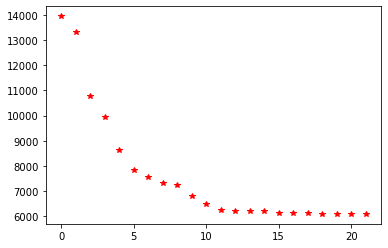

In [10]:
# plots the performance of the genetic algoithm
fig2 = plt.figure(2)
plt.plot(outlist, "r*")
plt.show()

# Comparing random search with genetic algorithm 

In [11]:
def compareoptimzers(numtries=21):
    
    '''
    performs numtries amount of each algorithm and outputs the objective value of each try in lists. a counter is also printed 
    to show the number of tries of using each function f or g during the evaluation
    '''

    RSoutcome = []  # stores the outputs of the RS
    GAoutcome = []  # stores the outputs of the GA

    # RS parameters
    best_obj = 100000
    best_x = np.array([])
    fobjlist = []
    max_iterations = 4000  # max number of evaluations allowed for any of the functions
    
    # GA parameters
    Nparents = 10
    crossoverperc = 0.1
    mutateperc = 0.2
    Niter = 100
    
    global funccounter
        
    for _ in range(numtries):
        
        funccounter = np.zeros(5)
        best_obj, _, _ = randomsearch(best_obj, best_x, fobjlist, max_iterations)
        RSoutcome.append(best_obj)
        print("func counter RS: ",funccounter)
        
        funccounter = np.zeros(5)
        _, bestfitval, _ = geneticalgorithm(Nparents, fitfunc, Niter, crossoverperc, mutateperc, funccounteron = True)
        GAoutcome.append(bestfitval)
        print("func counter GA: ",funccounter)
        
    return RSoutcome, GAoutcome

In [12]:
rs,ga = compareoptimzers()

print("Results of Random Search: ")
print(rs)

print("Results of Genetic Algorithm: ")
print(ga)

func counter RS:  [4000.  300.  257.  197.  197.]
func counter GA:  [4006. 3311. 3308. 3304. 3304.]
func counter RS:  [4000.  236.  214.  157.  157.]
func counter GA:  [4016. 3513. 3472. 3381. 3381.]
func counter RS:  [4000.  205.  167.  122.  122.]
func counter GA:  [4010. 3342. 3331. 3293. 3293.]
func counter RS:  [4000.  202.  179.  136.  136.]
func counter GA:  [3998. 3469. 3448. 3299. 3299.]
func counter RS:  [4000.  180.  152.  122.  122.]
func counter GA:  [4036. 3415. 3400. 3339. 3339.]
func counter RS:  [4000.  199.  170.  137.  137.]
func counter GA:  [4003. 3419. 3405. 3338. 3338.]
func counter RS:  [4000.  228.  196.  151.  151.]
func counter GA:  [4027. 3539. 3515. 3402. 3402.]
func counter RS:  [4000.  201.  167.  127.  127.]
func counter GA:  [4022. 3696. 3679. 3524. 3524.]
func counter RS:  [4000.  182.  157.  117.  117.]
func counter GA:  [4026. 3610. 3474. 3389. 3389.]
func counter RS:  [4000.  189.  166.  132.  132.]
func counter GA:  [3990. 3322. 3319. 3307. 3307.]


# Particle Swarm


In [13]:
# ## I made this as I didn't see the typo in the first issue of the CW. Including it so you can see my process.

# def generateparents(Nparents):
#     parents = []
#     i = 0
#     while i < Nparents:
#         x_curr = np.array([random.randint(80, maxx1x2),  # x1
#                            random.randint(80, maxx1x2),  # x2
#                            180 + (maxx3x4 - 180) * random.random(),  # x3
#                            180 + (maxx3x4 - 180) * random.random()])  # x4
#         if g1(x_curr) <= z2(x_curr):
#             if g2(x_curr) <= z1(x_curr):
#                 if g3(x_curr) <= maxg3:
#                     if g4(x_curr) <= maxg4:
#                         parents.append(x_curr)
#                         i += 1

#     return np.array(parents)


# def getfittestparent(parents, fitfunc):
#     fitvals = np.array([fitfunc(i) for i in parents])
#     bestind = np.argmin(fitvals)
#     # print("fit vals: ", fitvals)
#     # print("Best parent: ", parents[bestind])
#     # print("Best obj value: ", fitvals[bestind])
#     return parents[bestind], fitvals[bestind]

# def particleswarm(Nparents, fitfunc, Niter, a0, a1, a2):
#     parents = generateparents(Nparents)
#     fitvals = np.array([fitfunc(i) for i in parents])
#     bestparent, bestfitval = getfittestparent(parents, fitfunc)
#     vel_list = np.zeros([Nparents, 4])
#     globalbestparent, globalbestfitval = bestparent, bestfitval
#     pos_list = parents
#     print("start   :", bestfitval, bestparent)
#     for i in range(Niter):
#         for j in range(Nparents):
#             vel_list[j] = a0*vel_list[j] + a1 * random.random() * (parents[j] - pos_list[j]) + a2 * random.random() * (globalbestparent - pos_list[j])
#             pos_list[j] = pos_list[j] + vel_list[j]
#             newpart = checkconstraints(pos_list[j], [])
#             if np.array_equal(newpart, pos_list[j]):

#                 if fitfunc(pos_list[j]) < fitvals[j]:
#                     parents[j] = pos_list[j]
#                     fitvals[j] = fitfunc(pos_list[j])
#             else:
#                 pos_list[j] = newpart
#                 fitvals[j] = fitfunc(newpart)

#         globalbestparent, globalbestfitval = getfittestparent(parents, fitfunc)

#         if i % 1 == 0:
#             print(f'"At iteration {i}/{Niter} : {globalbestfitval} {globalbestparent}"')

#     print("Best objective value: ", globalbestfitval)
#     print("Best parameters: ", globalbestparent)
#     return bestparent, bestfitval

# particleswarm(Nparents=1000, fitfunc=f, Niter=1000, a0=0.4, a1=2, a2=2)
